In [1]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Simulation space dimensions, etc. edited by Clarke 02.21.2022
nx = 161
ny = 161
xmax = 2000.0 # micrometers
ymax = 2000.0
x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]
nxmid = int(nx/2); print('nxmid =', nxmid); print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Define the box inside
Ldesired = 35. # Doesn't always work out to this because the grid is discretized
boxrad = int(Ldesired/dx)
L = boxrad*dx; print('L =', L)
ixbox = [ix for ix in range(nxmid-boxrad,nxmid+boxrad)]; #print ixbox
iybox = [iy for iy in range(nymid-boxrad,nymid+boxrad)]; #print iybox
ixbot = min(ixbox); #print ixbot
ixtop = max(ixbox); #print ixtop
iylft = min(iybox); #print iylft
iyrgt = max(iybox); #rint iyrgt

# Compute diffusion coefficient at this temperature
D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
Temp = 260.0
Pressure = .2
acoef = 2.072
D = D_300*(Temp/300)**acoef/(Pressure/1.0); print(D_300, D)

# Here's the part that involved some guesswork ... getting the Neumann coefficient
gneumann_nu_kin = D/(nx-1); print('gneumann_kin', gneumann_nu_kin)
nu_kin_ml = 0.1633333333
kfactor = gneumann_nu_kin/nu_kin_ml; print('kfactor', kfactor)
alphasigma = .36; print('alpha*sigma', alphasigma)
gneumann = kfactor * nu_kin_ml; print('gneumann', gneumann)

# This is the far-field boundary
udirichlet = alphasigma

# Aesthetics ... fills in the box with an arbitrary constant value
def fillin(un,ixbox,iybox):
    border = cp(un[ixbox[0]-1,iybox[0]])
    for ix in ixbox:        
        for iy in iybox:
            un[ix,iy] = border
    return un

# Initialize u0 and un as ones/zeros matrices 
u0 = np.ones([nx, ny])*udirichlet # old u values
u0 = fillin(u0,ixbox, iybox)
u1 = cp(u0)

dx 12.5
nxmid = 80
x(nxmid) = 1000.0
L = 25.0
24.0 89.20943386022752
gneumann_kin 0.557558961626422
kfactor 3.4136262963686304
alpha*sigma 0.36
gneumann 0.557558961626422


In [4]:
# Physical parameters translated into values for computation
dx2 = dx**2
dy2 = dy**2
dt = (dx2+dy2)/D/10; print(dt)
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2
gneumanneff = gneumann*dt/dx**2; print('gneumann effective', gneumanneff)

# The differential equation solver
def propagate(u0_orig):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
    
    # Neumann inner boundary
    un[ixbot-1,iybox] = u0[ixbot-1,iybox] +(u0[ixbot-2,iybox] - u0[ixbot-1,iybox])*Dxeff -gneumanneff
    un[ixtop+1,iybox] = u0[ixtop+1,iybox] +(u0[ixtop+2,iybox] - u0[ixtop+1,iybox])*Dxeff -gneumanneff
    un[ixbox,iylft-1] = u0[ixbox,iylft-1] +(u0[ixbox,iylft-2] - u0[ixbox,iylft-1])*Dxeff -gneumanneff
    un[ixbox,iyrgt+1] = u0[ixbox,iyrgt+1] +(u0[ixbox,iyrgt+2] - u0[ixbox,iyrgt+1])*Dxeff -gneumanneff
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox)
    
    return un


0.35029927495069857
gneumann effective 0.00125


In [5]:
# Propagate forward a bunch of times
ntimes = 5000
un = propagate(u0)
for i in range(ntimes):
    un = propagate(un)

<IPython.core.display.Javascript object>


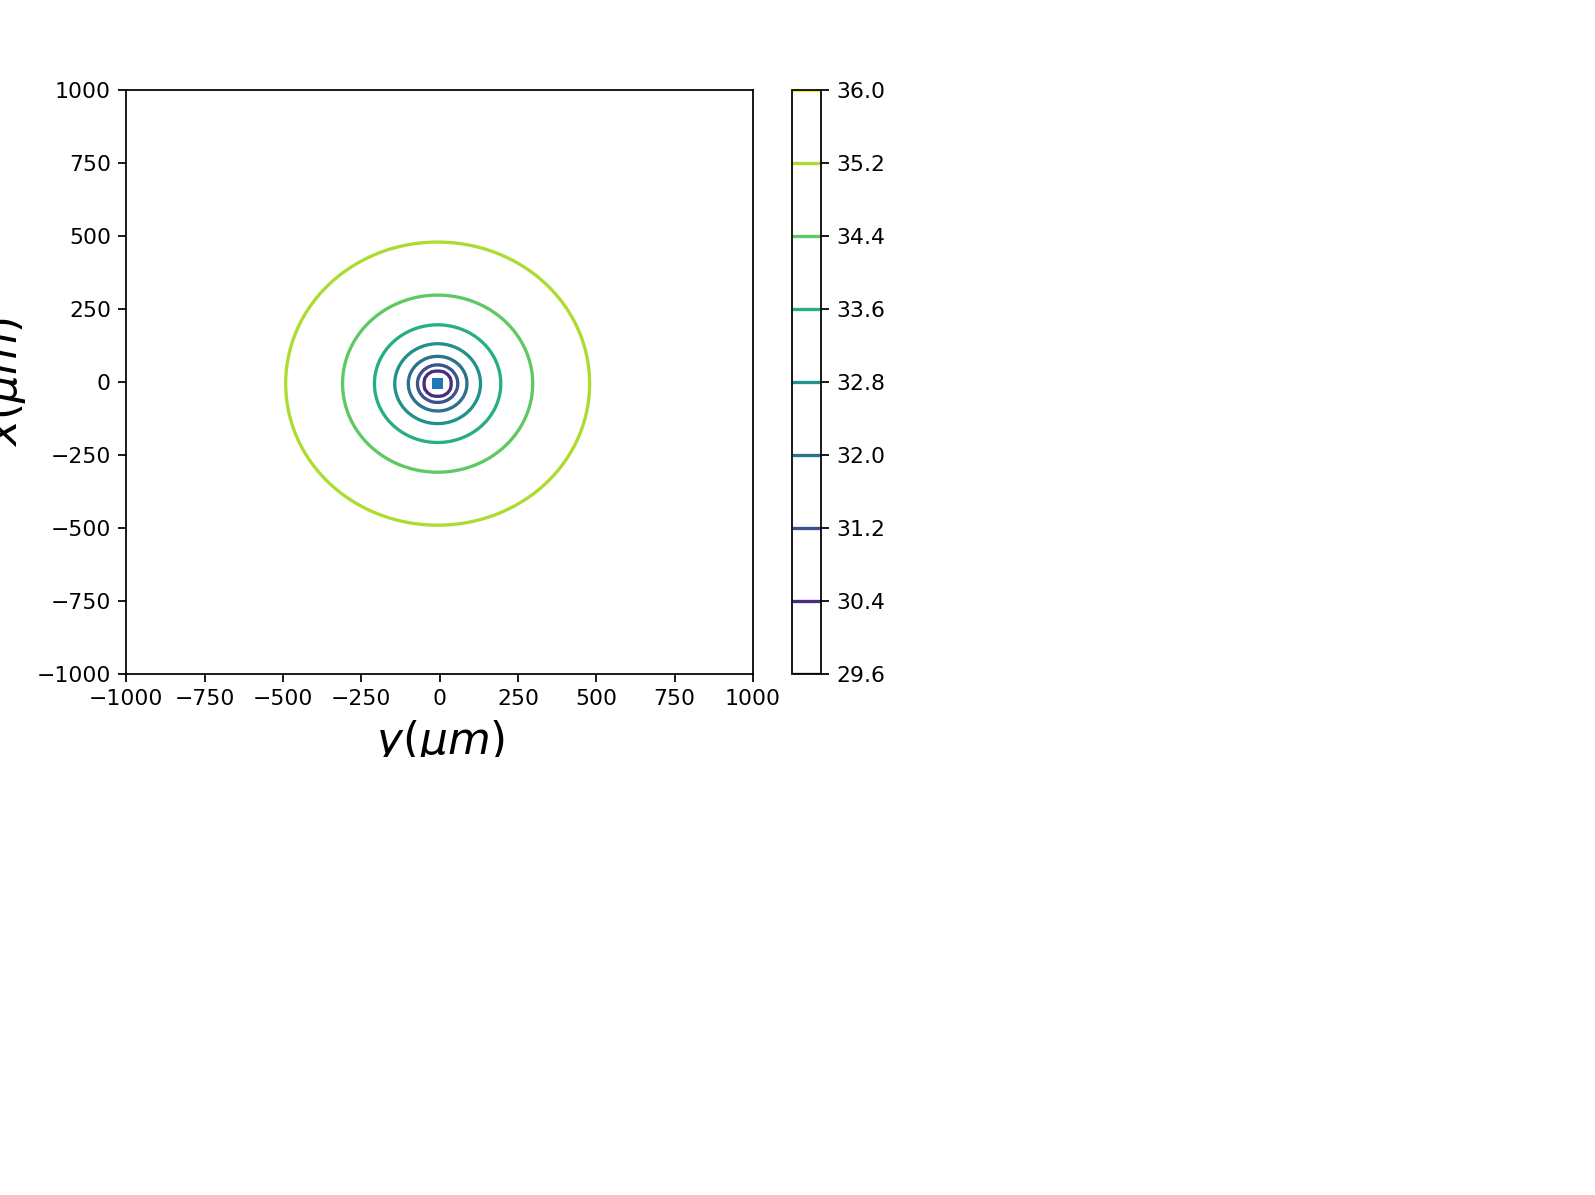

In [6]:
# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(y,x,un*100)
ax.set_xlabel(r'$y (\mu m)$', fontsize=20)
ax.set_ylabel(r'$x (\mu m)$', fontsize=20)
fig.colorbar(CS)
ax.add_patch(patches.Rectangle((y[iybox[0]],x[ixbox[0]]), L*2-dy, L*2-dx))

<IPython.core.display.Javascript object>


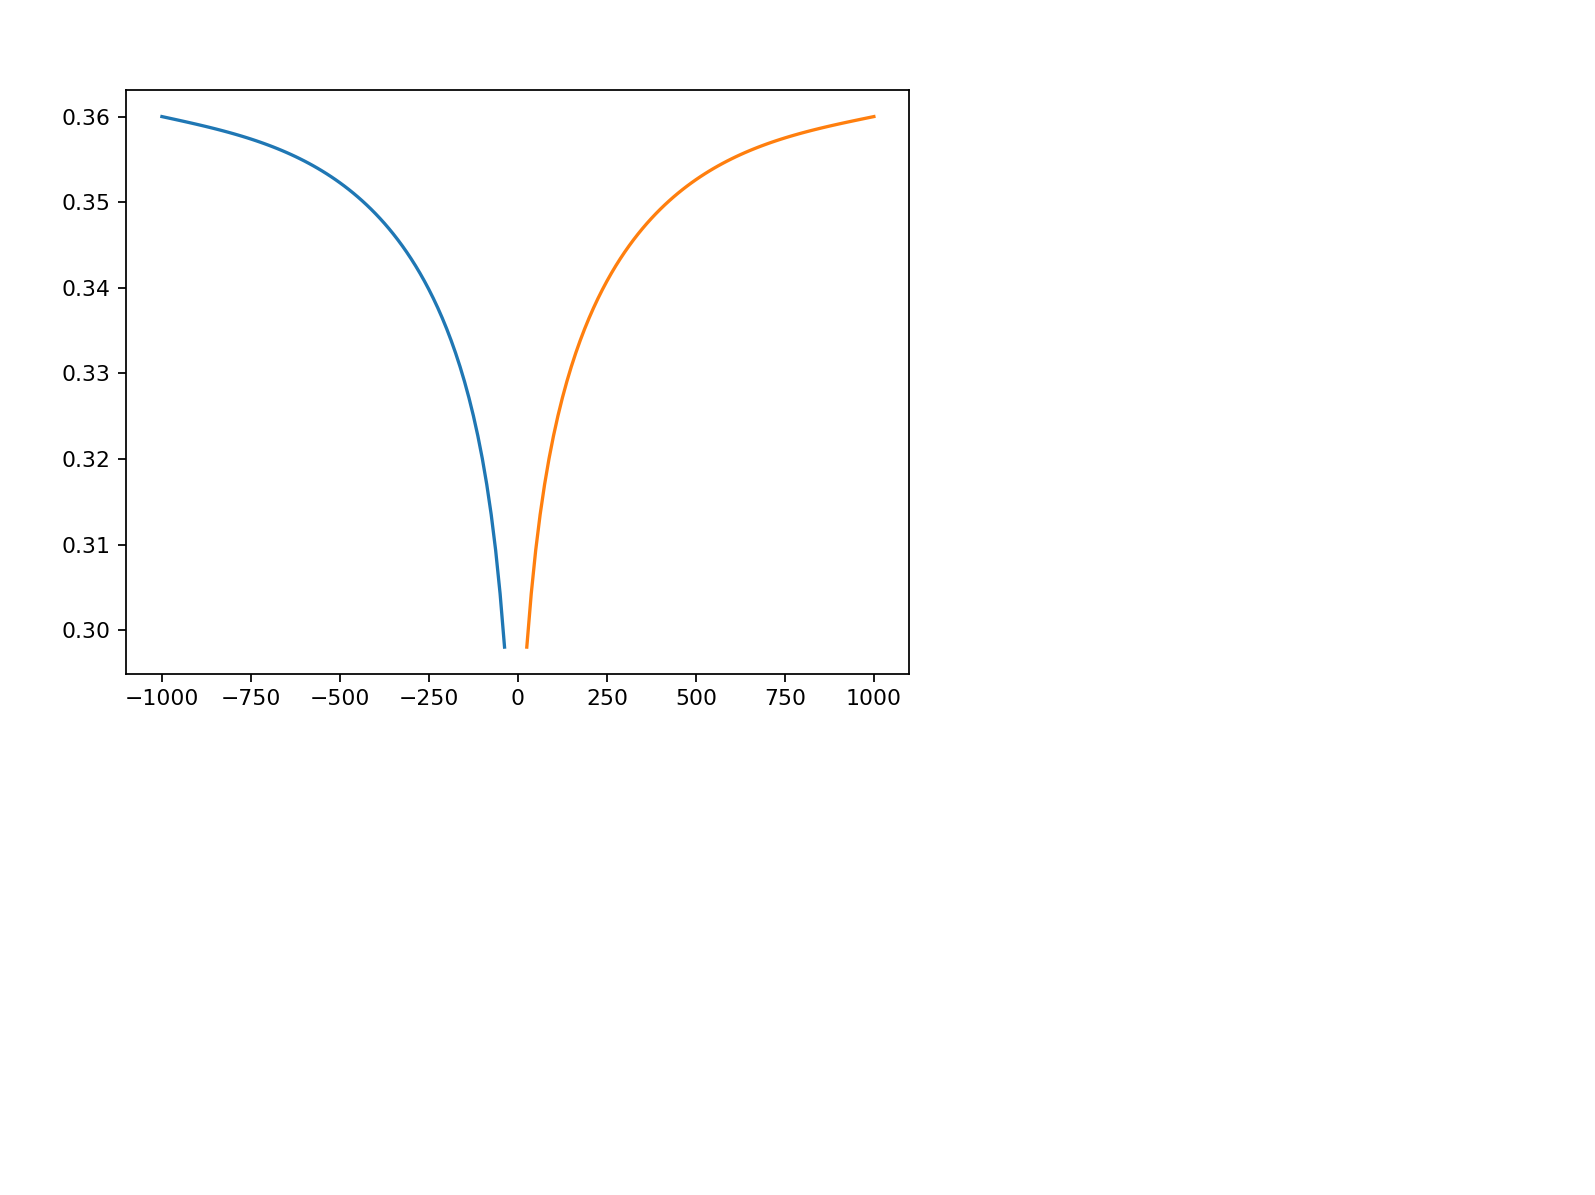

<IPython.core.display.Javascript object>


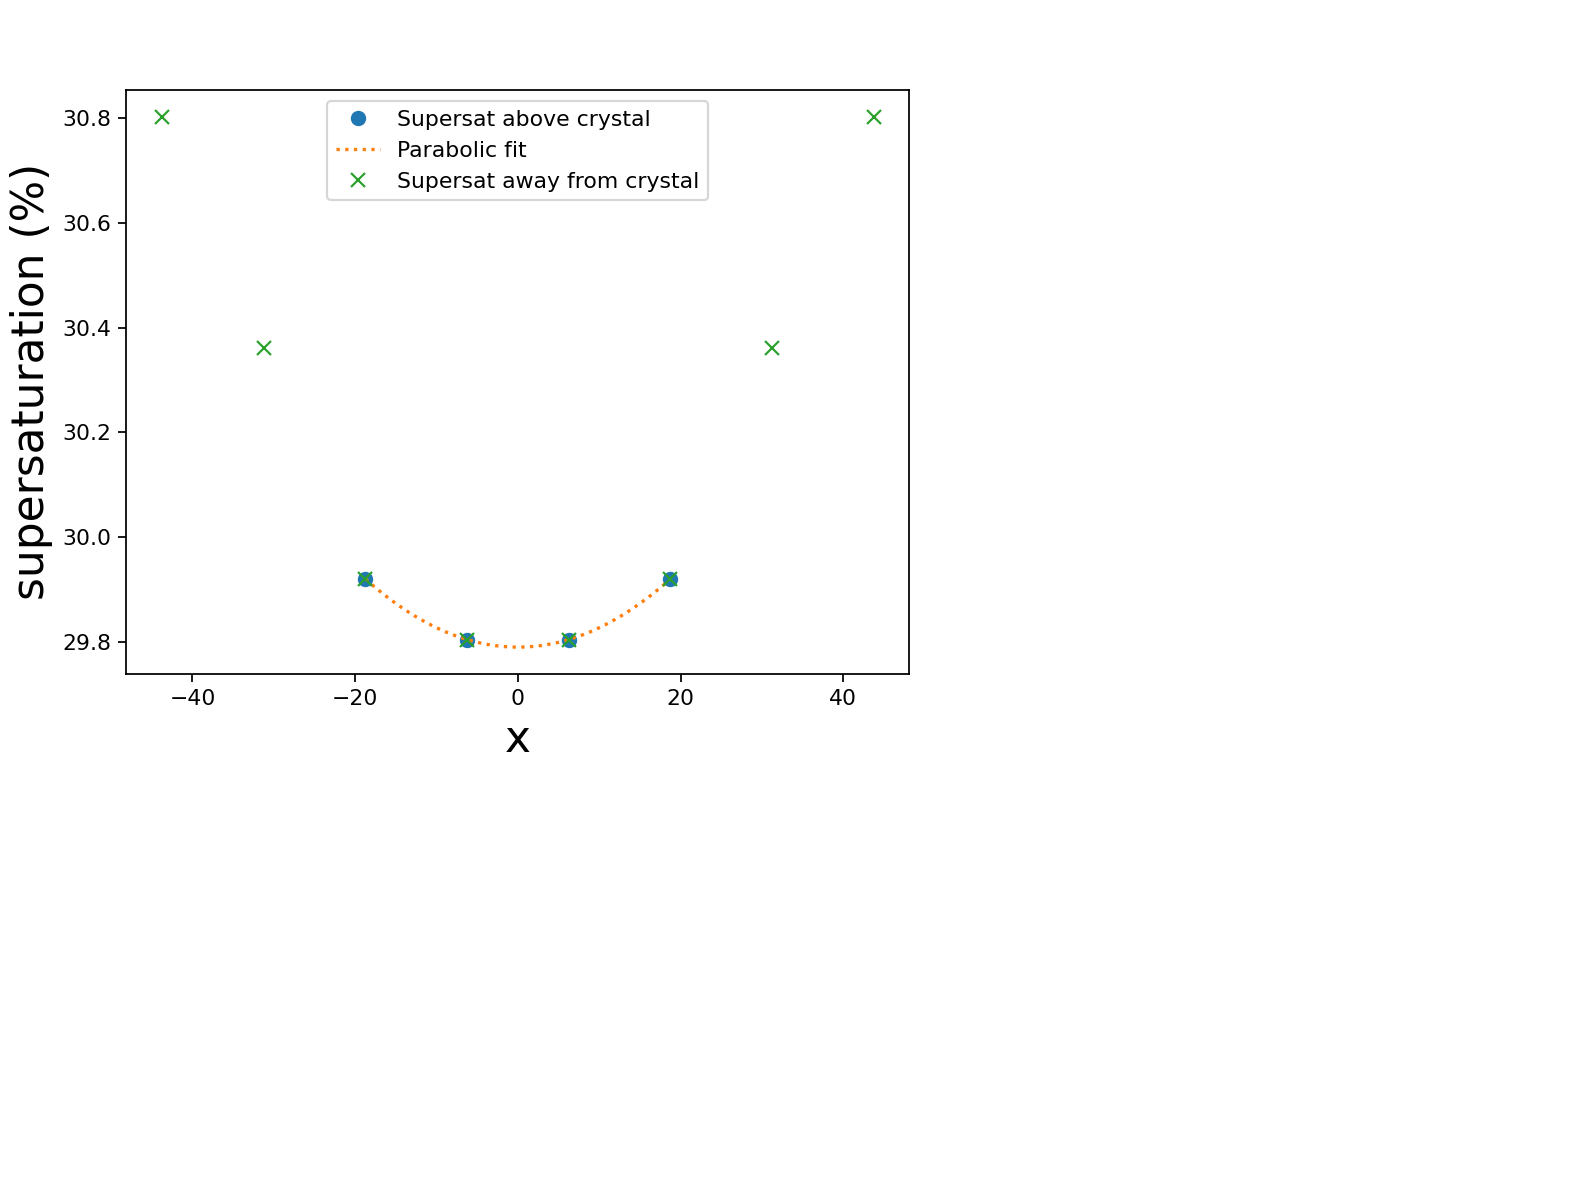

c_r = 0.11584460049802181
[ 3.70668901e-06 -4.23872113e-09  2.97896760e-01]


In [7]:
# Show slices through the result

# Just a slice down the middle
plt.figure()
plt.plot(x[:ixbot],un[:ixbot,nymid])
plt.plot(x[ixtop+1:],un[ixtop+1:,nymid])

# Now a slice just across one of the box surfaces
plt.figure()
#uscaled = un[ixbox,nymid+boxrad]/max(un[ixbox,nymid+boxrad])
uscaled = un[ixbox,nymid+boxrad]
print('c_r =', (max(uscaled)-min(uscaled))*100)
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uscaled*100,'o')
p = np.polyfit(xshifted,uscaled,2); print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory)*100,':')

iextend = 2
bigixbox = [ix for ix in range(nxmid-boxrad-iextend,nxmid+boxrad+iextend)]
biguscaled = un[bigixbox,nymid+boxrad]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguscaled*100,'x',lw=2)
plt.xlabel('x',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
# plt.xlim([-L*1.,L*1.1])

plt.legend(['Supersat above crystal','Parabolic fit','Supersat away from crystal'],loc='upper center')
